# Assignment: Risk predicition of criminal re-offense



**This notebook** presents an exploration of a sub-set of data from **[SAVRY](https://www.parinc.com/Products/Pkey/390)** (Structured Assessment of Violence Risk in Youth) applied to young offenders in Catalonia. 

SAVRY is a risk assessment tool, that supports structured professional judgement. SAVRY contains 24 risk factors, in which each item (variables `V65*` to `V88*`) can have one of three values (low=0, moderate=1, high=2), for a total score between 0 and 48 points. 

+ Human score: There is also a score by a professional (variable `V56_@R1_resum_risc_global_reverse`) that can be low, moderate, or high. 
+ Recividism: In this dataset, there is information about whether people committed a new crime after the evaluation.  The variable `V115_reincidencia_2015` represents Recidivism (year 2015).
+ The variable `V60_SAVRY_total_score` contains a sum of scores in the risk items of SAVRY. This score can be seen as a baseline automatic method.

Features values can be found in ``reincidenciaJusticiaMenors.xlsx``. The description of features can be found in ``recidivismJuvenileJustice_variables_EN.pdf``. The data file we use is a subset of data obtained by the Centre d'Estudis Jurídics i Formació Especialitzada of the Catalan government and released in 2017.

The objectives of this assignment are: 
+ To compare the performance of SAVRY and ML-based methods, in terms of both performace and fairness metrics. 
+ To analyze the causes of unfairness.
+ To explore a mitigation strategy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

### Data Exploration

In [2]:
FILENAME_DATASET = 'data/reincidenciaJusticiaMenors.xlsx'

df = pd.read_excel(FILENAME_DATASET)
df.head()

,id,V1_sexe,V2_estranger,V3_nacionalitat,V4_nacionalitat_agrupat,V5_edat_fet_agrupat,V6_provincia,V7_comarca,V8_edat_fet,V9_edat_final_programa,...,V123_rein_fet_agrupat_2013,V124_rein_fet_violencia_2013,V125_rein_fet_tipus_2013,V126_primera_reincidencia_2013,V127_rein_programa_2013,V128_rein_programa_agrupat_2013,V129_on_reincidencia_2013,V130_nombre_rein_agrupat_2013,V131_severitat_puntuacio_2013,V132_REINCIDENCIA_2013
0,691,Home,Espanyol,Espanya,NaN,14 i 15 anys,Lleida,Segrià,15.0,17,...,Contra la propietat no violent,No violent,Delicte,Presó,SIPC - Preventiva,Presó,Només Presó,2 o 3 reincidències,2.0,Sí
1,956,Dona,Espanyol,Espanya,NaN,14 i 15 anys,Barcelona,Barcelonès,14.0,15,...,Contra la propietat no violent,No violent,Delicte,Justícia juvenil,Assessorament tècnic menors,ATM,Només JJ,2 o 3 reincidències,1.0,Sí
2,2560,Home,Estranger,Marroc,Magrib,14 i 15 anys,Barcelona,Anoia,15.0,16,...,Altres,No violent,Delicte,Justícia juvenil,Realització de tasques socioeducatives,Altres MO,Justícia juvenil i presó,Més de 3 reincidències,2.0,Sí
3,2018,Home,Estranger,Marroc,Magrib,14 i 15 anys,Girona,Gironès,14.0,15,...,Altres,No violent,Delicte,Justícia juvenil,Permanència de cap de setmana en centre,Internament,Només JJ,Més de 3 reincidències,3.0,Sí
4,1650,Home,Espanyol,Espanya,NaN,16 i 17 anys,Tarragona,Tarragonès,17.0,20,...,Altres,No violent,Delicte,MPA,MPA - Treballs en benefici de la comunitat,TBC,Només MPA,1 reincidència,1.0,Sí


In [3]:
for k,i in enumerate(list(df.columns)):
    print(k,i)

0 id
1 V1_sexe
2 V2_estranger
3 V3_nacionalitat
4 V4_nacionalitat_agrupat
5 V5_edat_fet_agrupat
6 V6_provincia
7 V7_comarca
8 V8_edat_fet
9 V9_edat_final_programa
10 V10_data_naixement
11 xxxxxxxx_FETS
12 V11_antecedents
13 V12_nombre_ante_agrupat
14 V13_nombre_fets_agrupat
15 V14_fet
16 V15_fet_agrupat
17 V16_fet_violencia
18 V17_fet_tipus
19 V19_fets_desagrupats
20 V20_nombre_antecedents
21 V21_fet_nombre
22 V22_data_fet
23 xxxxxxxx_PROGRAMA
24 V23_territori
25 V24_programa
26 V25_programa_mesura
27 V26_mesures
28 V27_durada_programa_agrupat
29 V28_temps_inici
30 V29_durada_programa
31 V30_data_inici_programa
32 V31_data_fi_programa
33 xxxxxxxxxxxxxx_MRM
34 V32_MRM_resultat
35 V33_MRM_participacio_victima
36 V34_MRM_tipus
37 V35_MRM_forma
38 V36_MRM_negatiu
39 V37_MRM_conciliacio_victimaexlus
40 V38_MRM_reparacio_economica
41 V39_MRM_reparacio_noeconomica
42 V40_MRM_reparacio_comunitaria
43 V41_MRM_participacio_trobada
44 V42_MRM_participacio_notrobada
45 V43_MRM_iniciativa_parts
46 

In [4]:
# data cleaning

df = df.dropna(subset=["V60_SAVRY_total_score", 
                       "V8_edat_fet", 
                       "V20_nombre_antecedents", 
                       "V89_@P1_impicacio_prosocial", 
                       "V90_@P2_suport_social_fort",
                       "V91_@P3_forta_vinculacio_adult_prosocial", 
                       "V92_@P4_actitud_positiva_intervencions_autoritat",
                       "V93_@P5_fort_compromis_escola_treball", 
                       "V94_@P6_perseverança_tret_personalitat"])
df = df.drop(df[df["V60_SAVRY_total_score"]>48].index)

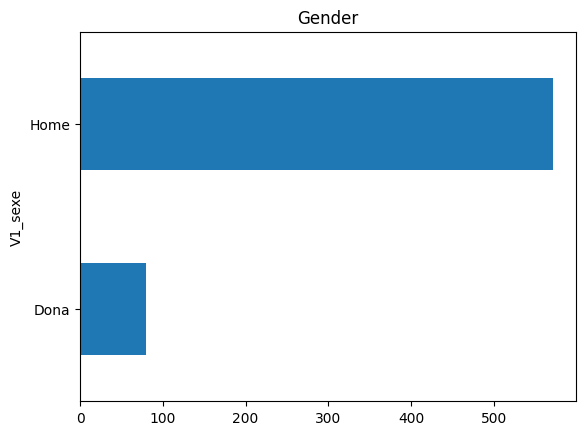

In [5]:
# data distribution by gender

_ = df['V1_sexe'].value_counts(ascending=True).plot(kind='barh', title='Gender')

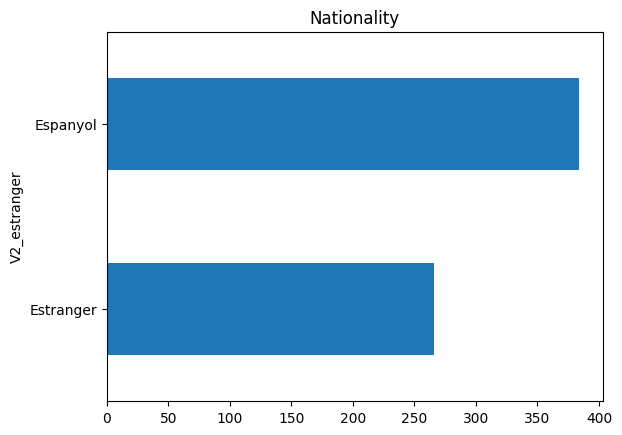

In [6]:
# data distribution by nationality

_ = df['V2_estranger'].value_counts(ascending=True).plot(kind='barh', title='Nationality')

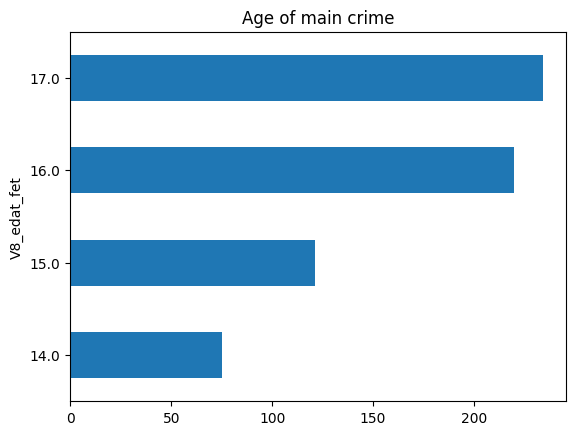

In [7]:
# data distribution by age

_ = df['V8_edat_fet'].value_counts(ascending=True).plot(kind='barh', title='Age of main crime')

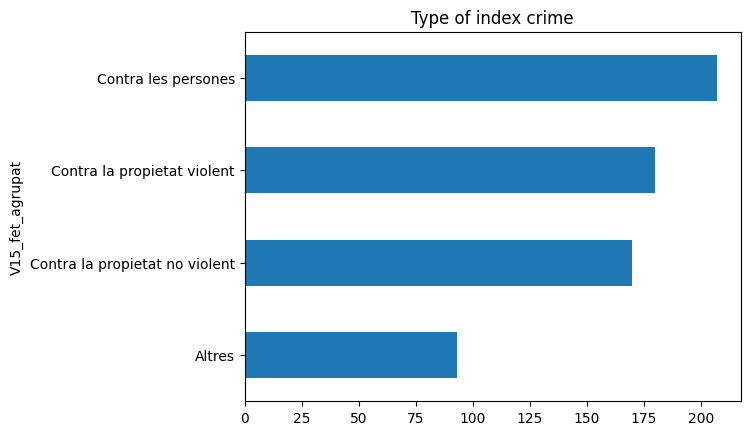

In [8]:
# data distribution by type of index crime

_ = df['V15_fet_agrupat'].value_counts(ascending=True).plot(kind='barh', title='Type of index crime')

## SAVRY model (human assessment)

The column `V56_@R1_resum_risc_global_reverse` is an evaluation done by a professional expert (that can be low, moderate, or high), based on the results of SAVRY but **applying his/her own judgment independently of the obtained score**.

The expert rates each defendant as "low", "medium", or "high" risk. Ideally, defendants considered low risk should recidivate at a lower rate than defendants considered high risk.

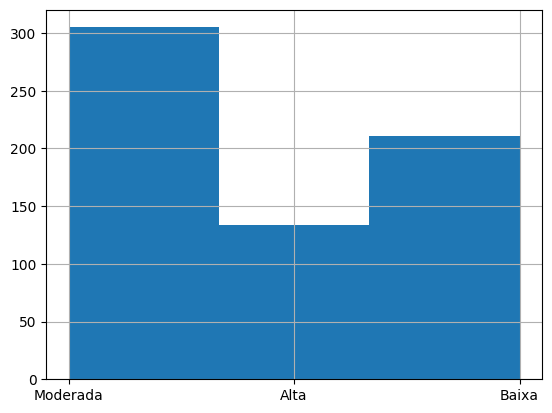

In [9]:
# human score distribution

hist = df['V56_@R1_resum_risc_global_reverse'].hist(bins=3)

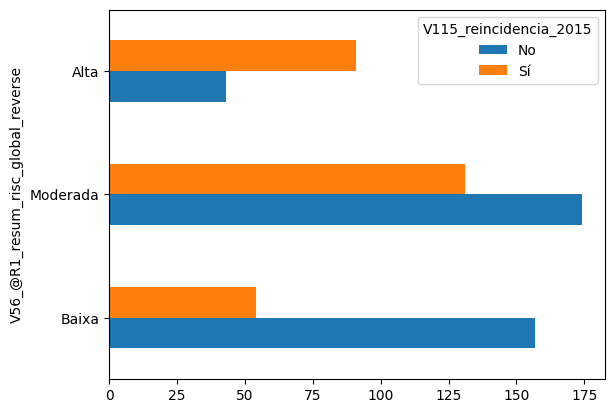

In [10]:
# human score distribution | recividism

human_ctable = pd.crosstab(df['V56_@R1_resum_risc_global_reverse'], df['V115_reincidencia_2015'])
human_ctable = human_ctable.reindex(index=["Baixa", "Moderada", "Alta"])
_ = human_ctable.plot(kind='barh')

In [11]:
# recividism rate per score

human_ctable["recidivism_rate"] = pd.Series(index=human_ctable.index, dtype='float')
for index, row in human_ctable.iterrows():
    recidivism_rate =row["Sí"] / (row["Sí"] + row["No"])
    human_ctable.at[index, "recidivism_rate"] = recidivism_rate
    
human_ctable

V115_reincidencia_2015,No,Sí,recidivism_rate
V56_@R1_resum_risc_global_reverse,,,
Baixa,157,54,0.255924
Moderada,174,131,0.429508
Alta,43,91,0.679104


### Baseline model

Our baseline prediction can be based on the column `V60_SAVRY_total_score`, which contains a sum of scores in the risk items of SAVRY. The max value of this sum is 40.

In [12]:
scores_recidivists = df[df["V115_reincidencia_2015"]=='Sí']["V60_SAVRY_total_score"].values
scores_non_recidivists = df[df["V115_reincidencia_2015"]=='No']["V60_SAVRY_total_score"].values

In [13]:
def compare_histograms(scores1, scores2, title, label1='Recidivists', label2='Non recidivists'):
    plt.figure(figsize=(10,6))
    plt.hist(scores1, histtype='step', label=label1, density=True, color='red')
    plt.hist(scores2, histtype='step', label=label2, density=True, color='blue')
    plt.legend(loc='upper right', fontsize='x-large')
    plt.ylabel('Probability')
    plt.xlabel(title)
    plt.show()

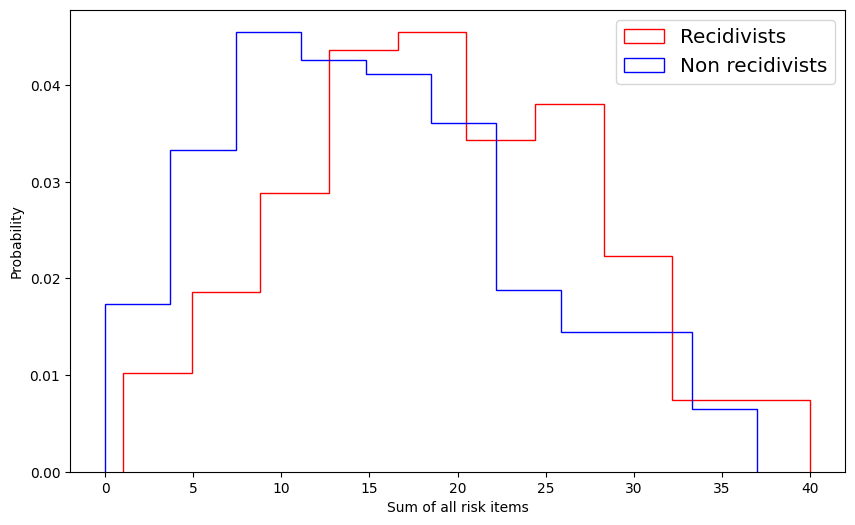

In [14]:
## baseline score distribution

compare_histograms(scores_recidivists, scores_non_recidivists, 'Sum of all risk items')

In [15]:
def draw_roc_curve( ground_truth, predictions, pos_label="Sí"):
    fpr, tpr, thresholds = roc_curve(ground_truth, predictions, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right", fontsize='x-large')
    plt.show()
    return roc_auc

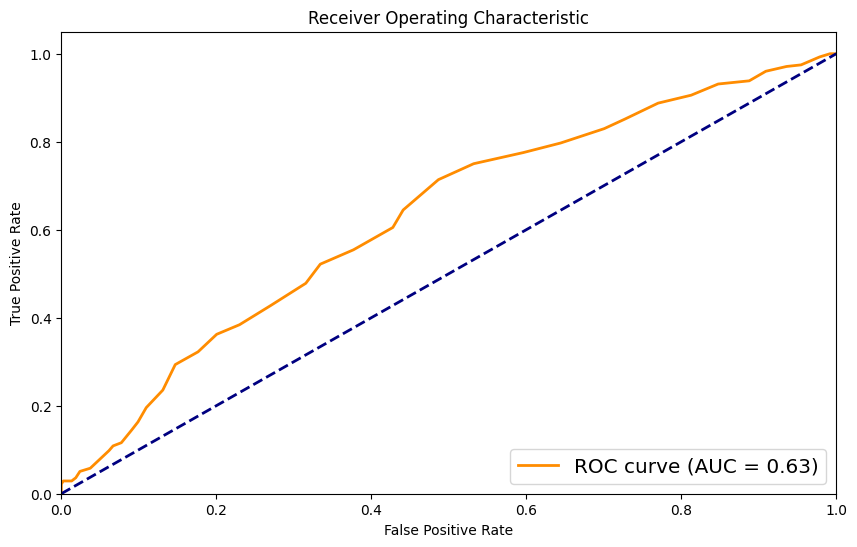

In [16]:
# Evaluation (ROC curve) of the baseline prediction

_ = draw_roc_curve(df["V115_reincidencia_2015"].values, df["V60_SAVRY_total_score"].values)

## Modeling recidivism using logistic regression

Logistic regression is a simple yet effective classification model for this problem.

In all cases above we will use the same training/testing split, which is done randomly, keeping 1/3 of the data for testing. You can repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [17]:
train, test = train_test_split(df, test_size=0.33)

### Modeling recidivism (24 risk factors)

Now we model recidivism by using the 24 risk factors in SAVRY.

Note that the performance depends on the training/testing split which is done randomly, keeping 1/3 of the data for testing. Repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [18]:
risk_factor_columns = list(df.columns)[70:94]

train_X = pd.get_dummies(train[risk_factor_columns])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[risk_factor_columns])
test_y = test["V115_reincidencia_2015"]

In [19]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [20]:
pred24_y = model.predict_proba(test_X)[:,1]
pred24_recidivists = pred24_y[test_y == 'Sí']
pred24_non_recidivists = pred24_y[test_y == 'No']

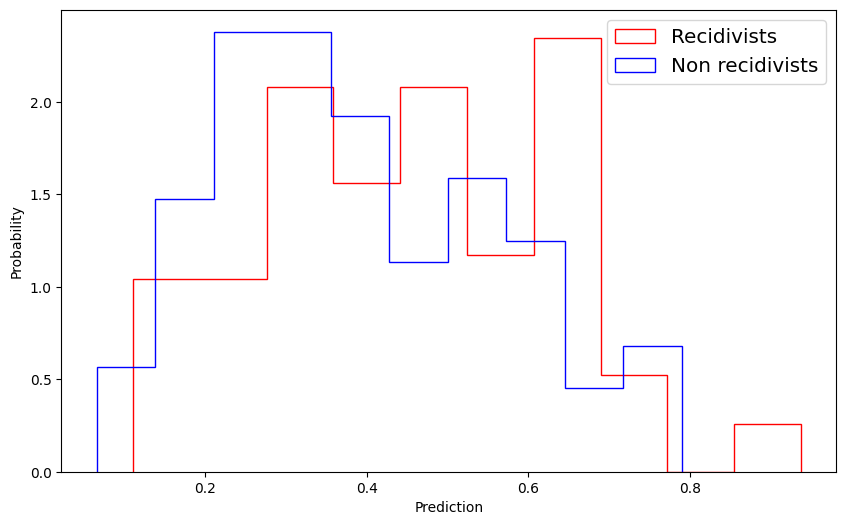

In [21]:
compare_histograms(pred24_recidivists, pred24_non_recidivists, 'Prediction')

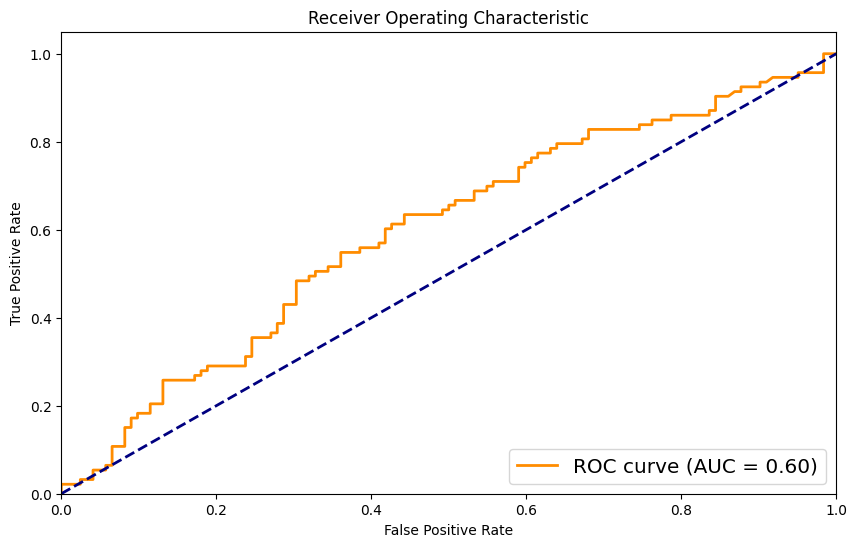

In [22]:
_ = draw_roc_curve(test_y, pred24_y)

### Modeling recidivism (personal history factors)

Next we use demographic factors: gender and nationality, as well as criminal history factors such as the age of commission of the index crime and its type, as well as whether the juvenile defendant has criminal records.

In [23]:
demographic_columns = ["V1_sexe", 
                       "V2_estranger", 
                       "V8_edat_fet", 
                       "V20_nombre_antecedents",
                       "V15_fet_agrupat", 
                       "V16_fet_violencia"]
                       
train_X = pd.get_dummies(train[demographic_columns])
train_y = train["V115_reincidencia_2015"]

test_X =  pd.get_dummies(test[demographic_columns])
test_y = test["V115_reincidencia_2015"]

In [24]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [25]:
predPH_y = model.predict_proba(test_X)[:,1]
predPH_recidivists = predPH_y[test_y == 'Sí']
predPH_non_recidivists = predPH_y[test_y == 'No']

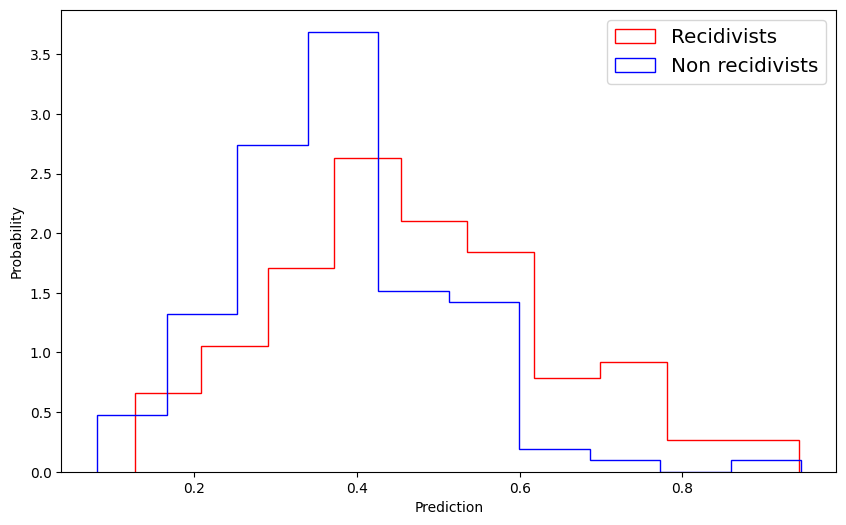

In [26]:
compare_histograms(predPH_recidivists, predPH_non_recidivists, 'Prediction')

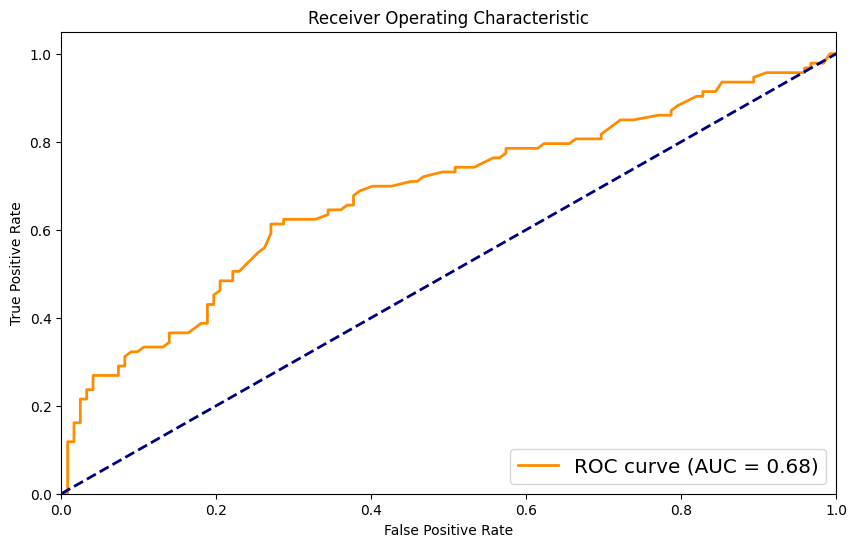

In [27]:
_ = draw_roc_curve(test_y, predPH_y)

### Modeling recidivism (personal history + 24 risk factors + 6 protective factors)

We now add to the above 6 "protective" or positive factors that are associated with a low risk.

In [28]:
protective_factor_columns = ["V89_@P1_impicacio_prosocial", 
                             "V90_@P2_suport_social_fort",
                             "V91_@P3_forta_vinculacio_adult_prosocial", 
                             "V92_@P4_actitud_positiva_intervencions_autoritat",
                             "V93_@P5_fort_compromis_escola_treball", 
                             "V94_@P6_perseverança_tret_personalitat"]

factors = demographic_columns + risk_factor_columns + protective_factor_columns

train_X = pd.get_dummies(train[factors])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[factors])
test_y = test["V115_reincidencia_2015"]

In [29]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [30]:
predALL_y = model.predict_proba(test_X)[:,1]
predALL_recidivists = predALL_y[test_y == 'Sí']
predALL_non_recidivists = predALL_y[test_y == 'No']

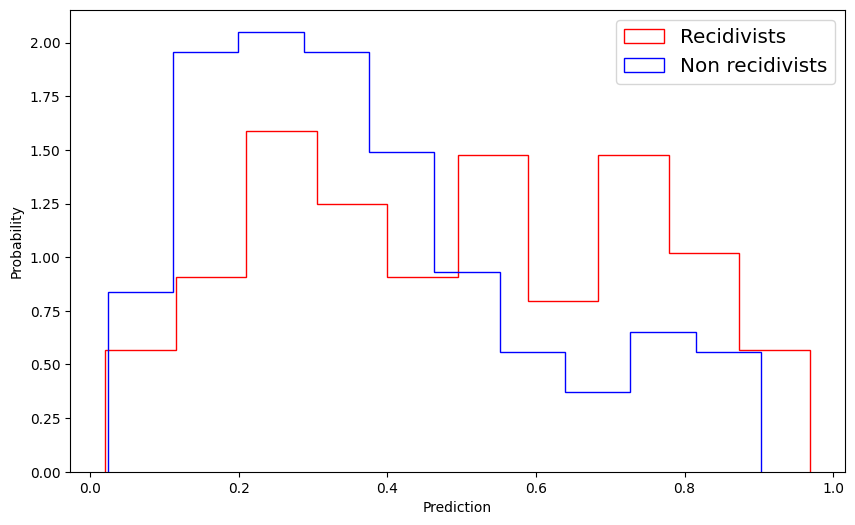

In [31]:
compare_histograms(predALL_recidivists, predALL_non_recidivists, 'Prediction')

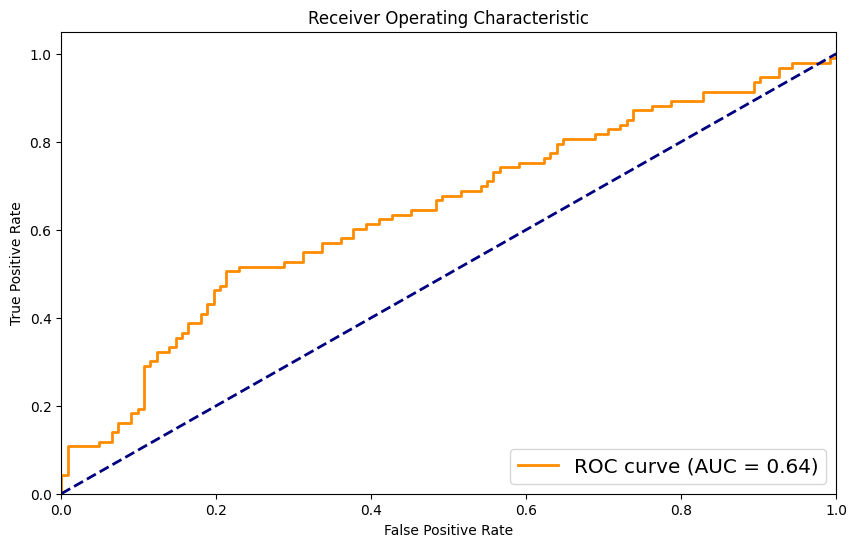

In [32]:
_ = draw_roc_curve(test_y, predALL_y)

# Recidivism and fairness
We remark that fairness is not necessarily that people in different groups obtain the same outcomes. For instance, in this dataset, women recidivate at about half the rate as men, and foreigners at a higher rate than nationals.

In [33]:
recidivism_by_gender = pd.crosstab(df["V115_reincidencia_2015"], df["V1_sexe"])
recidivism_by_gender['Dona'] = recidivism_by_gender['Dona'] / recidivism_by_gender['Dona'].sum()
recidivism_by_gender['Home'] = recidivism_by_gender['Home'] / recidivism_by_gender['Home'].sum()
recidivism_by_gender

V1_sexe,Dona,Home
V115_reincidencia_2015,,
No,0.759494,0.549912
Sí,0.240506,0.450088


In [34]:
recidivism_by_nationality = pd.crosstab(df["V115_reincidencia_2015"], df["V2_estranger"])
recidivism_by_nationality['Espanyol'] = recidivism_by_nationality['Espanyol'] / recidivism_by_nationality['Espanyol'].sum()
recidivism_by_nationality['Estranger'] = recidivism_by_nationality['Estranger'] / recidivism_by_nationality['Estranger'].sum()
recidivism_by_nationality

V2_estranger,Espanyol,Estranger
V115_reincidencia_2015,,
No,0.632812,0.492481
Sí,0.367188,0.507519


# Fairness as **equality of error rates**

We can look at fairness as **equality of error rates**.

## Professional (human expert) recidivism prediction and fairness

We consider people who did not recidivate, in particular, look at those who were given a "high" risk by the expert.

In [35]:
non_recidivists = df[df["V115_reincidencia_2015"] == 'No']
non_recidivists_expert_by_gender = pd.crosstab(non_recidivists["V56_@R1_resum_risc_global_reverse"], non_recidivists["V1_sexe"])
non_recidivists_expert_by_gender.reindex(index=["Baix", "Moderat", "Alt"])
non_recidivists_expert_by_gender["Home"] = non_recidivists_expert_by_gender["Home"] / non_recidivists_expert_by_gender["Home"].sum()
non_recidivists_expert_by_gender["Dona"] = non_recidivists_expert_by_gender["Dona"] / non_recidivists_expert_by_gender["Dona"].sum()
non_recidivists_expert_by_gender

V1_sexe,Dona,Home
V56_@R1_resum_risc_global_reverse,,
Alta,0.116667,0.114650
Baixa,0.433333,0.417197
Moderada,0.450000,0.468153


In [36]:
non_recidivists_expert_by_nationality = pd.crosstab(non_recidivists["V56_@R1_resum_risc_global_reverse"], non_recidivists["V2_estranger"])
non_recidivists_expert_by_nationality.reindex(index=["Baix", "Moderat", "Alt"])
non_recidivists_expert_by_nationality["Espanyol"] = non_recidivists_expert_by_nationality["Espanyol"] / non_recidivists_expert_by_nationality["Espanyol"].sum()
non_recidivists_expert_by_nationality["Estranger"] = non_recidivists_expert_by_nationality["Estranger"] / non_recidivists_expert_by_nationality["Estranger"].sum()
non_recidivists_expert_by_nationality

V2_estranger,Espanyol,Estranger
V56_@R1_resum_risc_global_reverse,,
Alta,0.106996,0.129771
Baixa,0.423868,0.412214
Moderada,0.469136,0.458015


## Overall SAVRY score and fairness

In [37]:
scores_men_non_recidivists = df[(df["V115_reincidencia_2015"]=='Sí') &
                                      (df["V1_sexe"]=='Home')]["V60_SAVRY_total_score"].values
scores_women_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                       (df["V1_sexe"]=='Dona')]["V60_SAVRY_total_score"].values

print("Average SAVRY score of men non-recidivist: %.2f" %
      (scores_men_non_recidivists.sum() / len(scores_men_non_recidivists)))
       
print("Average SAVRY score of women non-recidivist: %.2f" % 
      (scores_women_non_recidivists.sum() / len(scores_women_non_recidivists)))

Average SAVRY score of men non-recidivist: 19.12
Average SAVRY score of women non-recidivist: 15.67


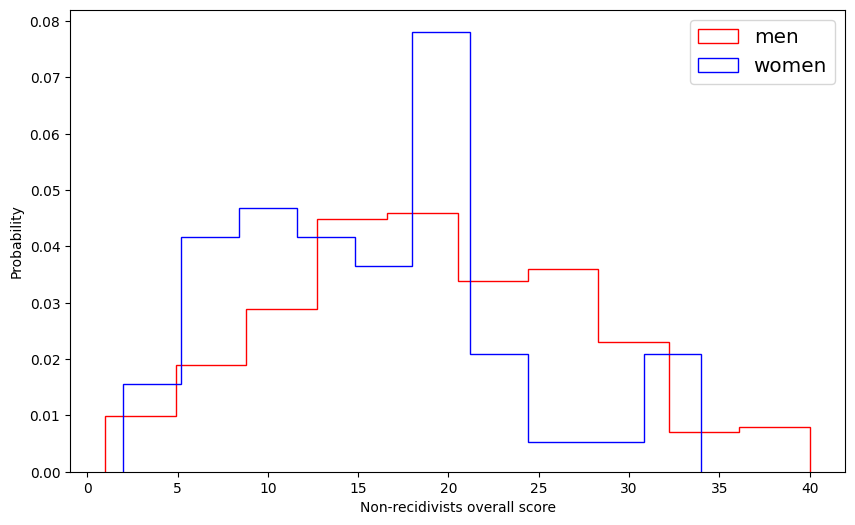

In [38]:
compare_histograms(scores_men_non_recidivists, scores_women_non_recidivists,
                   "Non-recidivists overall score",
                   label1="men", label2="women")

In [39]:
scores_nationals_non_recidivists = df[(df["V115_reincidencia_2015"]=='Sí') &
                                      (df["V2_estranger"]=='Espanyol')]["V60_SAVRY_total_score"].values
scores_foreigners_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                       (df["V2_estranger"]=='Estranger')]["V60_SAVRY_total_score"].values

print("Average SAVRY score of national non-recidivist: %.2f" %
      (scores_nationals_non_recidivists.sum() / len(scores_nationals_non_recidivists)))
       
print("Average SAVRY score of foreigner non-recidivist: %.2f" % 
      (scores_foreigners_non_recidivists.sum() / len(scores_foreigners_non_recidivists)))

Average SAVRY score of national non-recidivist: 18.89
Average SAVRY score of foreigner non-recidivist: 16.51


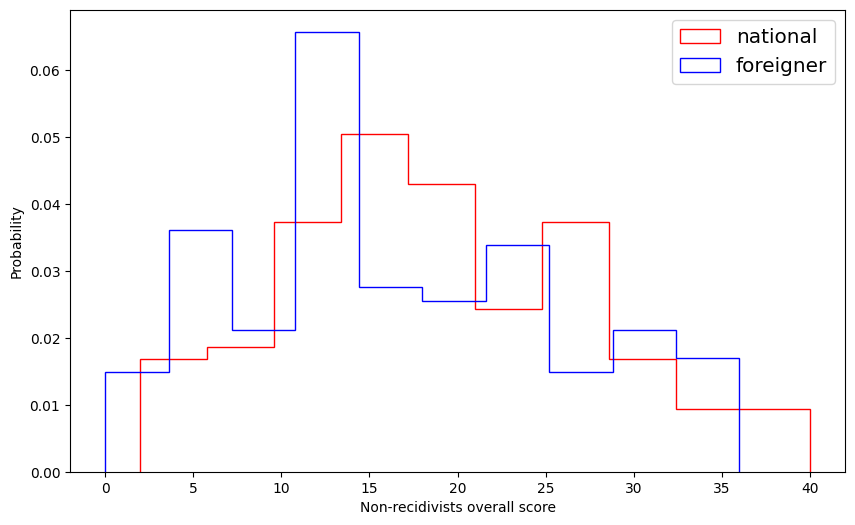

In [40]:
compare_histograms(scores_nationals_non_recidivists, scores_foreigners_non_recidivists,
                   "Non-recidivists overall score",
                   label1="national", label2="foreigner")

## Fairness using ML score

In [41]:
predPH_men_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
predPH_women_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]

print("Average predicted probability of men non-recidivist: %.2f" %
      (predPH_men_non_recidivists.sum() / len(predPH_men_non_recidivists)))
       
print("Average predicted probability of women non-recidivist: %.2f" % 
      (predPH_women_non_recidivists.sum() / len(predPH_women_non_recidivists)))

Average predicted probability of men non-recidivist: 0.40
Average predicted probability of women non-recidivist: 0.21


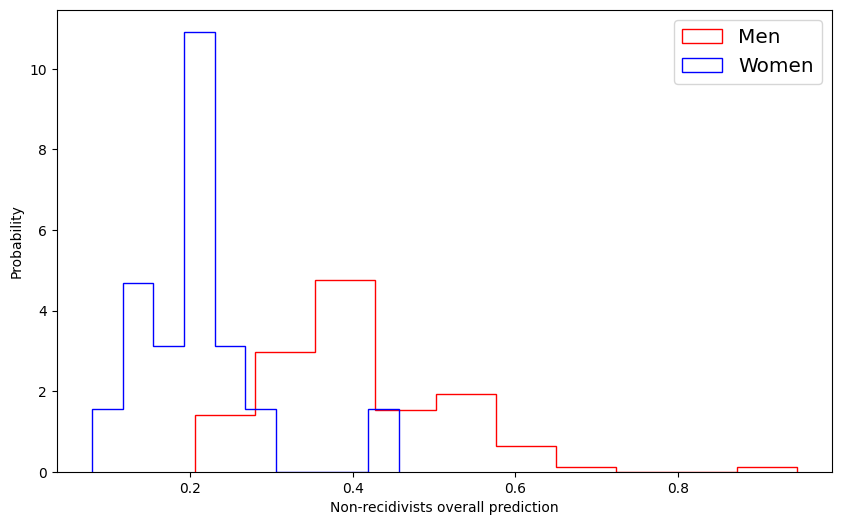

In [42]:
compare_histograms(predPH_men_non_recidivists, predPH_women_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Men", label2="Women")

In [43]:
predPH_nationals_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
predPH_foreigners_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]

print("Average predicted probability of national non-recidivist: %.2f" %
      (predPH_nationals_non_recidivists.sum() / len(predPH_nationals_non_recidivists)))
       
print("Average predicted probability of foreigner non-recidivist: %.2f" % 
      (predPH_foreigners_non_recidivists.sum() / len(predPH_foreigners_non_recidivists)))

Average predicted probability of national non-recidivist: 0.33
Average predicted probability of foreigner non-recidivist: 0.45


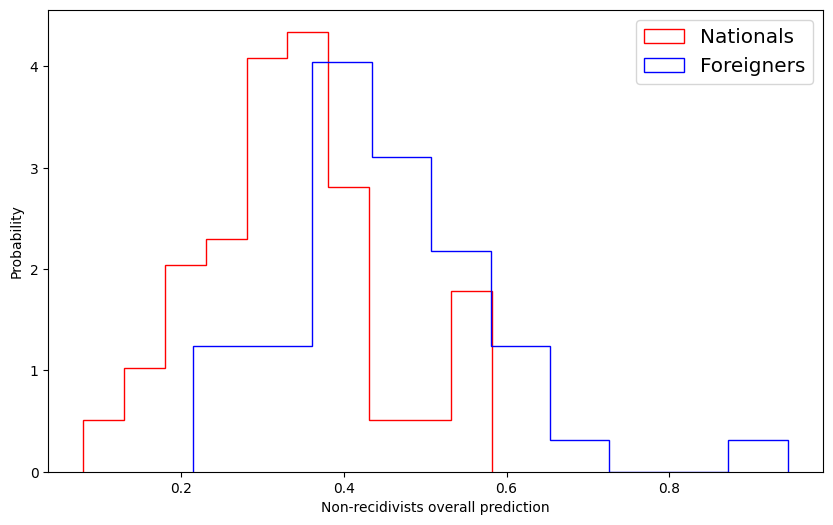

In [44]:
compare_histograms(predPH_nationals_non_recidivists, predPH_foreigners_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Nationals", label2="Foreigners")

# Exercise 1

1. Use different machine learning models (SVM, Random Forests, etc.) to check if you can increase the performance of the logistic regression model. 
2. Check if they satisfy the proposed fairness criteria. 
3. Compare several fairness criteria, such as Demographic Parity, Equal Opportunity, Equalized Odds, and Conditional Demographic Parity. 

### Questions (justify your answers)

1. Is there a method that can achieve better predictive power than human experts? 


2. Is this method better than human experts in terms of fairness?


3. Which is the most suited fairness criterium for this problem? Why?


4. What are your conclusion about the use of a ML model to predict recividism?



### Bias Metrics Analysis

In order to proceed with the metrics analysis, first, we will do a grid seachr to in order to tune the models. The models choosen for this exercise, besides the LinearRegression model proposed in the problem statement will be: RandomForrestClassifier, SVC and MLP Classifier.
We then compare the different ML methods, we will use the SAVRY score as a baseline for the comparison of the metrics.
The metrics will be:
- Equalised Error Rates
- Equalised Opprotunities
- Equalised Odds
- Demographic Parity

The dimension we will analyse these metrics for will be:
- Gender
- Nationality

For each metric, we will analyse how it differs among the different categories of the dimensions mentioned above.
We could use the difference of the average of each metric among the categories. But in order to make it more informative of the actual distribution among the categories of each dimension, and since the subject is sensible (it can make or destroy someone's life) in order to cover for worst case scenarios, we will be using the statistic resultion from performing a Kolmagorov-Smirnov test for the samples of the categories.
This satistic tells us the maximum difference between the empirical cumulative distribution functions (ECDFs) of the two samples. In the ordinary use of this test, if the test statistic is greater than a critical value, then the null hypothesis that the two samples come from the same distribution is rejected.

In our case, we will use this statistic as a proxy for bias. The greater it is, the greater the difference in the distribution of the sample. So, for our fairness metrics, the ideal method should give lower values of this metric.

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from models import Model, ModelEvaluator
from utils import ks_sample_test

import warnings
warnings.filterwarnings('ignore')

models = [{'name':'Logistic Regresseion',
           'model': LogisticRegression(), 
           'params': dict(
                        C = [0.01, 0.1, 1, 10, 100, 1000], 
                        max_iter = [1000], 
                        random_state = [42])},

          {'name':'Random Forest',
           'model': RandomForestClassifier(), 
           'params': dict(
                        random_state= [42],
                        n_estimators= [10, 50, 100, 200],
                        class_weight= [None, "balanced"],
                        max_depth = [3, 4, 5, 6],
                        min_samples_split= [0.005, 0.01, 0.05],
                        min_samples_leaf= [0.005, 0.01, 0.05],
                        criterion = ["gini", "entropy"],
                        n_jobs= [-1])},

          {'name':'SVC',
           'model':SVC(probability=True), 
           'params': dict(
                        random_state= [42],
                        kernel= ["linear", "poly", "rbf", "sigmoid"],
                        gamma= ["auto"],
                        C= [0.1, 0.5, 1, 5],
                        degree= [1, 2, 3, 4, 5])},

          {'name':'MLPClassifier',
            'model': MLPClassifier(), 
            'params': dict(
                        random_state = [42],
                        activation =  ["identity", "relu"],
                        learning_rate =  ["constant", "invscaling", "adaptive"],
                        max_iter =  [1000, 2000])}]

In [46]:
model_list = [Model(**model) for model in models]

train_X = pd.get_dummies(train[factors])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[factors])
test_y = test["V115_reincidencia_2015"]

evaluated_models = [ModelEvaluator(model = model) for model in model_list]

Model: Logistic Regresseion
Best params: {'C': 0.01, 'max_iter': 1000, 'random_state': 42}
Accuracy: 0.64
AUC: 0.71


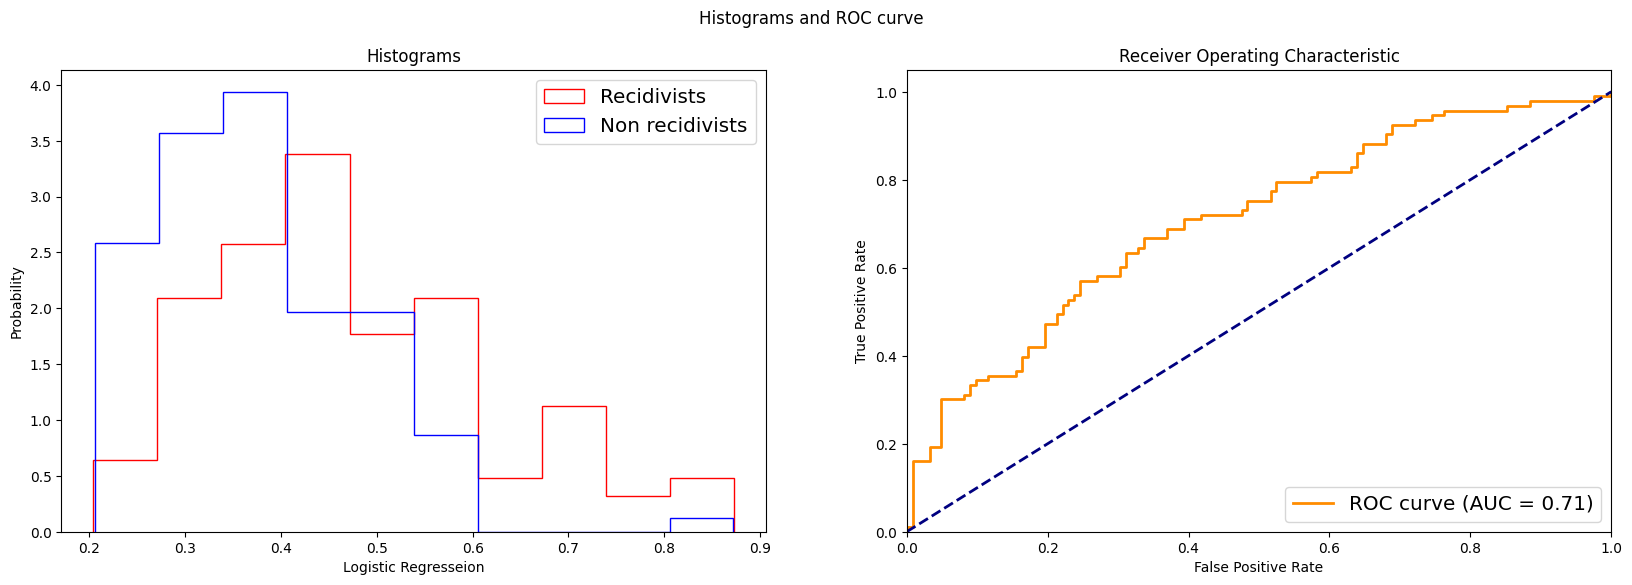

Model: Random Forest
Best params: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 0.01, 'min_samples_split': 0.005, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}
Accuracy: 0.65
AUC: 0.70


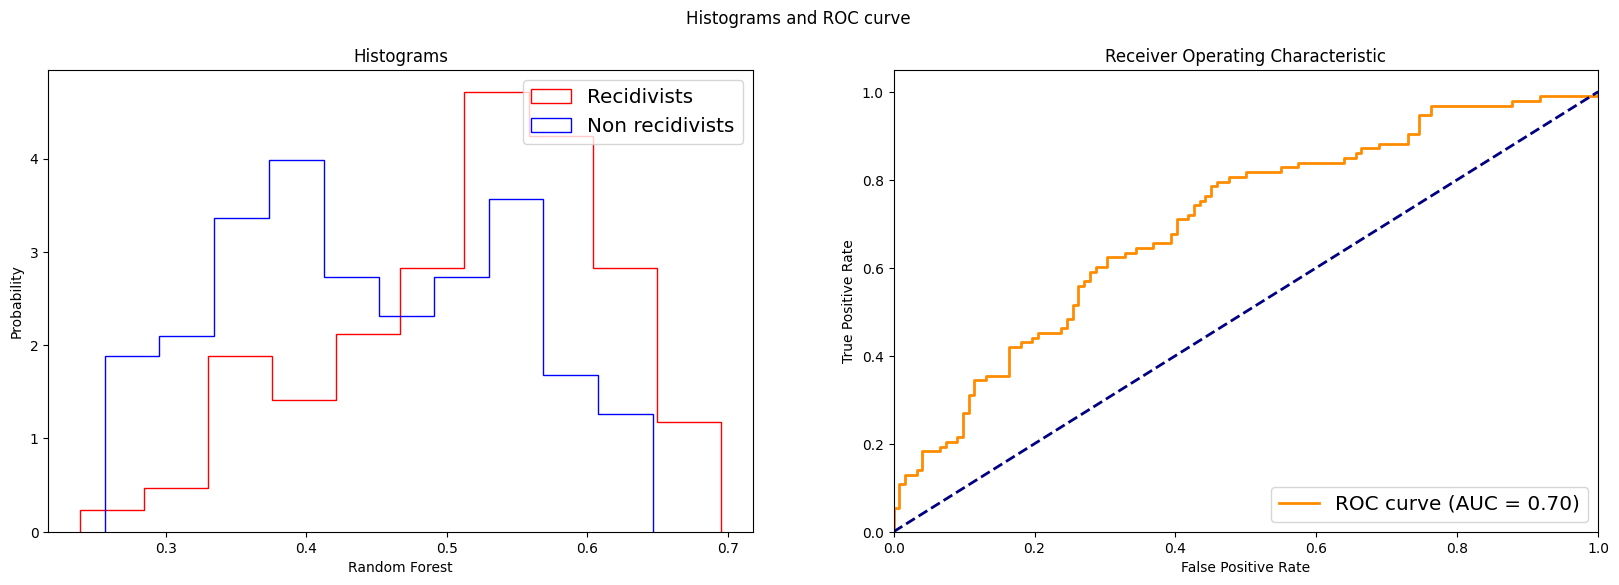

Model: SVC
Best params: {'C': 1, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly', 'random_state': 42}
Accuracy: 0.66
AUC: 0.71


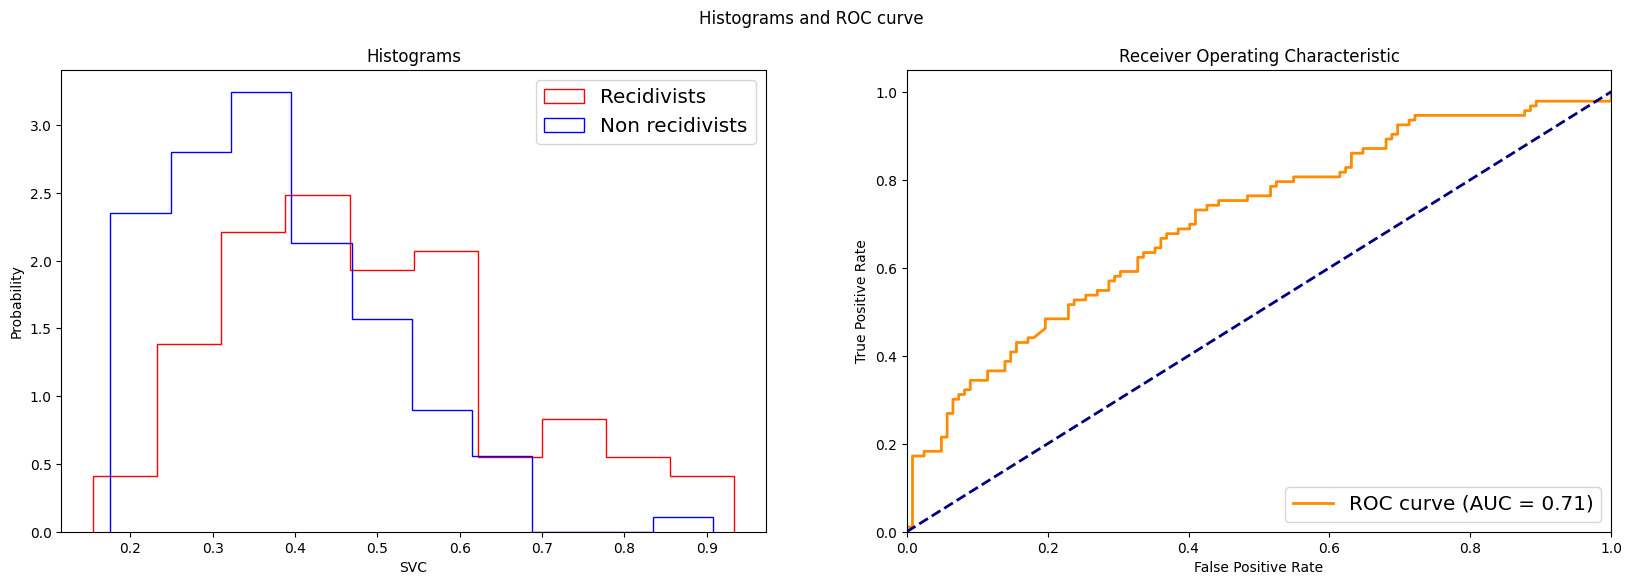

Model: MLPClassifier
Best params: {'activation': 'identity', 'learning_rate': 'constant', 'max_iter': 1000, 'random_state': 42}
Accuracy: 0.63
AUC: 0.64


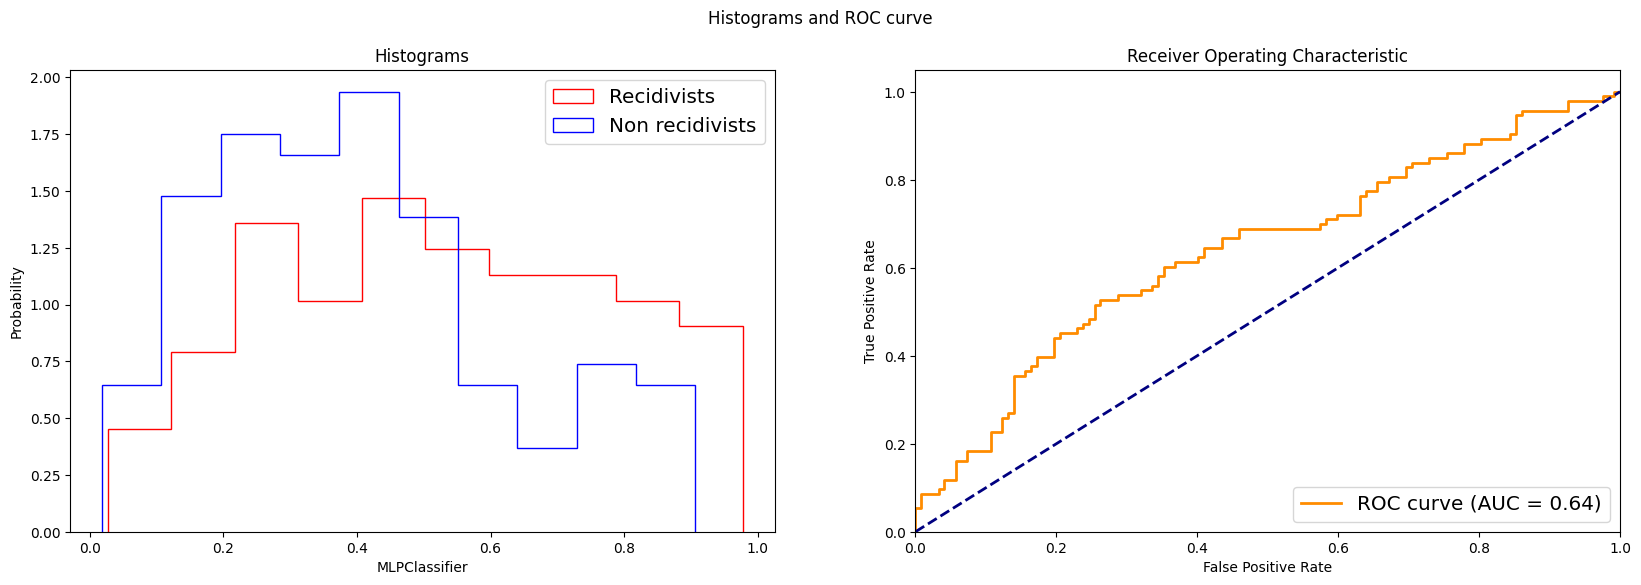

[None, None, None, None]

In [47]:
[model.evaluate(train_X, train_y, test_X, test_y) for model in evaluated_models]

As we can judge from the histograms, for all the mdoels there is significan overlap in the predicted probabilities. Specially in terms of False Negatives (predicted as non-recivist when they actually are). But given the how ehtically sensible the subject is, it can severy hinder someone's ability to live a good life. I would say it is not necessarily a bad thing.

We calculate the same metrics for the SAVRY score

In [48]:
non_rec_male = test[(test.V115_reincidencia_2015 == 'No') & (test.V1_sexe == 'Home')]['V60_SAVRY_total_score']
non_rec_female = test[(test.V115_reincidencia_2015 == 'No') & (test.V1_sexe == 'Dona')]['V60_SAVRY_total_score']
non_rec_national = test[(test.V115_reincidencia_2015 == 'No') & (test.V2_estranger == 'Espanyol')]['V60_SAVRY_total_score']
non_rec_foreigners = test[(test.V115_reincidencia_2015 == 'No') & (test.V2_estranger == 'Estranger')]['V60_SAVRY_total_score']

rec_male = test[(test.V115_reincidencia_2015 == 'Sí') & (test.V1_sexe == 'Home')]['V60_SAVRY_total_score']
rec_female = test[(test.V115_reincidencia_2015 == 'Sí') & (test.V1_sexe == 'Dona')]['V60_SAVRY_total_score']
rec_national = test[(test.V115_reincidencia_2015 == 'Sí') & (test.V2_estranger == 'Espanyol')]['V60_SAVRY_total_score']
rec_foreigners = test[(test.V115_reincidencia_2015 == 'Sí') & (test.V2_estranger == 'Estranger')]['V60_SAVRY_total_score']


male = test[(test.V1_sexe == 'Home')]['V60_SAVRY_total_score']
female = test[(test.V1_sexe == 'Dona')]['V60_SAVRY_total_score']
national = test[(test.V2_estranger == 'Espanyol')]['V60_SAVRY_total_score']
foreigners = test[(test.V2_estranger == 'Estranger')]['V60_SAVRY_total_score']


savry_equal_error_rates_gender = ks_sample_test(non_rec_male, non_rec_female)
savry_equal_error_rates_nationality = ks_sample_test(rec_national, rec_foreigners)

savry_equal_opportunity_gender = ks_sample_test(rec_male, rec_female)
savry_equal_opportunity_nationality = ks_sample_test(rec_national, rec_foreigners)

savry_demographic_parity_gender = ks_sample_test(male, female)
savry_demographic_parity_nationality = ks_sample_test(national, foreigners)

In [49]:
df_metrics = pd.DataFrame([{'model_name': model.model.name,
  'accuracy': model.accuracy,
  'auc': model.auc,
  'precision': model.precision,
  'recall': model.recall,
  'equal_error_rates_gender_bias': model.equal_error_rates_gender,
  'equal_error_rates_nationality_bias': model.equal_error_rates_nationality,
  'equal_opportunity_gender_bias': model.equal_opportunitty_gender,
  'equal_opportunity_nationality_bias': model.equal_opportunitty_nationality,
  'equal_odds_gender_bias': model.equal_odds_gender,
  'equal_odds_nationality_bias': model.equal_odds_nationality,
  'demographic_parity_gender_bias': model.demographic_parity_gender,
  'demographic_parity_nationality_bias': model.demographic_parity_nationality} for model in evaluated_models]
   + [{'model_name': 'SAVRY',
       'accuracy': None,
       'auc': None,
       'precision': None,
       'recall': None,
       'equal_error_rates_gender_bias': savry_equal_error_rates_gender,
       'equal_error_rates_nationality_bias': savry_equal_error_rates_nationality,
       'equal_opportunity_gender_bias': savry_equal_opportunity_gender,
       'equal_opportunity_nationality_bias': savry_equal_opportunity_nationality,
       'equal_odds_gender_bias': savry_equal_error_rates_gender + savry_equal_opportunity_gender,
       'equal_odds_nationality_bias': savry_equal_error_rates_nationality + savry_equal_opportunity_nationality,
       'demographic_parity_gender_bias': savry_demographic_parity_gender,
       'demographic_parity_nationality_bias': savry_demographic_parity_nationality
       }])

#### Traditional Performance metrics

In [50]:
df_metrics[['model_name', 'accuracy', 'auc', 'precision', 'recall']]

,model_name,accuracy,auc,precision,recall
0,Logistic Regresseion,0.637209,0.707650,0.647059,0.354839
1,Random Forest,0.651163,0.701393,0.591837,0.623656
2,SVC,0.655814,0.705976,0.679245,0.387097
3,MLPClassifier,0.632558,0.640402,0.583333,0.526882
4,SAVRY,NaN,NaN,NaN,NaN


#### Equal Error Rates

In [51]:
df_metrics[['model_name', 'equal_error_rates_gender_bias', 'equal_error_rates_nationality_bias']]

,model_name,equal_error_rates_gender_bias,equal_error_rates_nationality_bias
0,Logistic Regresseion,0.187115,0.333916
1,Random Forest,0.467787,0.299534
2,SVC,0.188796,0.329837
3,MLPClassifier,0.434174,0.357226
4,SAVRY,0.178711,0.182701


#### Equal Opportunity

In [52]:
df_metrics[['model_name', 'equal_opportunity_gender_bias', 'equal_opportunity_nationality_bias']]

,model_name,equal_opportunity_gender_bias,equal_opportunity_nationality_bias
0,Logistic Regresseion,0.373529,0.355689
1,Random Forest,0.569118,0.437558
2,SVC,0.326471,0.296022
3,MLPClassifier,0.420588,0.333950
4,SAVRY,0.151471,0.182701


#### Equalised Odds

In [53]:
df_metrics[['model_name', 'equal_odds_gender_bias', 'equal_odds_nationality_bias']]

,model_name,equal_odds_gender_bias,equal_odds_nationality_bias
0,Logistic Regresseion,0.560644,0.689605
1,Random Forest,1.036905,0.737092
2,SVC,0.515266,0.625859
3,MLPClassifier,0.854762,0.691176
4,SAVRY,0.330182,0.365402


#### Demographic Parity

In [54]:
df_metrics[['model_name', 'demographic_parity_gender_bias', 'demographic_parity_nationality_bias']]

,model_name,demographic_parity_gender_bias,demographic_parity_nationality_bias
0,Logistic Regresseion,0.282105,0.322667
1,Random Forest,0.507368,0.361333
2,SVC,0.243158,0.342222
3,MLPClassifier,0.408421,0.338667
4,SAVRY,0.193684,0.230222


From the metrics analysed above, we can quickly observe some conclusions. 1, no ML model (from the ones tried) beats the SAVRY at fairness. And among the models, the best in terms of performance and overall fairness seems to be the SVC.

#### Question 1
Is there any ML model that performs better in accuracy than a human?
- The answer to this quetion is more nuance that it seams. The human gives three possible categories (high risk, moderate risk and low risk). It is a multiclass prediction of three variables whereas our models are binary (yes or no). My best guess would be to say that given thea amount of information to be digested before making the assessment, the machine based methods might be better at learning some non-obvious patterns
#### Question 2
Is this method better than human experts in terms of fairness?
- For this question, we have the same difficulties for answering as in question 1. That said, if we look at the human experts decisions, they very equally distrbuted among the different categories of the dimensions. This makes me think that it would be hard to find a machine based method that beats that without any mitigation streategies

#### Question 3
Which is the most suited fairness criterium for this problem? Why?
- In calss we saw the article of a machine based method in the US that caused anger because it was way more likey to predict recividism for an afro-american than a white american. The creators of the algorithm then defended that it was well calibrated and that it only reflects the true proportions based on data.
The answer to this question heavily depends on what weighs more in our moral compas. Security (willing to sacrifice a portion of the population to the injustice of a prediction) or fairness (making sure that everyone is treated equal). And the truth is, for most societies the correct answer will lie somewhere in the middle. If we pose calibration at one end of one spectrum and demographic parity at the other, the correct answer for the most of us will be in the middle. In my humble opinion, it would be equal error rates. It prioritises fairness and it leaves the door open for positive discrimination.
But one thing is clear, this should not be a job for machines. It should be a job for humans assisted by michines instead.

#### Question 4
What are your conclusion about the use of a ML model to predict recividism?
- Based on my answer to question 3, my conclusion is that the use of ML to uncover unseen trends and digestion of data is great. But the final decision should be left to a human who takes multiple inputs besides just the data and whatever insight the ML models are able to provide. It is a decision that can make or destroy someone's life. I would even suggest that the expert makes the decision after a personal interview with the afected person.

# Exercise 2

We have seen that the bias in the data with respect to the protected features (sex, nationality) yields disparity between groups. To analyze the influence of data bias with respect to the protected features we can perform a comparison of the baseline, unrestricted data settings with one mitigation method that addresses these issues: equalized base rates (EBR). Differences in predictive performance, group fairness and the set of features, which are important for prediction, provide further insights in the role that these conditions play with respect to group fairness.

EBR assumes the following stratified oversampling procedure. Considering the input features $x$ and the outcomes $y$, a protected feature $f'$ has $I$ possible values corresponding to different groups: $\{g_1,…,g_I\}$, comprising a reference group $g_{ref}$. For each group $g_i$, different to the reference group, we compute the number of positive or negative condition samples $|S_i|$ we need to add to the training data, where $|S_i|$ is the absolute value of $S_i = P(x(f')=g_i)(P(y|x(f')=g_i) - P(y|x(f')=g_{ref}))$. 

If $S_i$ is negative then we add to the data $|S_i|$ negative condition samples $P(y=0| P(x(f')=g_i)$, while for $S_i$ positive we add $|S_i|$ positive condition samples $P(y=1| P(x(f')=g_i)$ of group $g_i$. This procedure yields equal base rates between the group $g_i$ and the reference group $g_{ref}$, namely $P(x(f')=g_i) = P(x(f')=g_{ref})$.

### Questions (justify your answers)

1. Is the application of this mitigation method sufficient to guarantee fair outcomes?

- The effectiveness of the EBR method in guaranteeing fair outcomes may depend on the distributions in the dataset. Classes that are significantly underrepresented may require a substantial oversampling. Without proper data augmentation techniques, the model might overfit to specific samples.
Moreover, balancing the representations may ironically break the balance within the classes. For instance, incramenting the sample of foreigners might mean that in doing so, we increment the samples of males in the data set in a higher propotion than females, and so on.
While EBR may be helpful in certain scenarios, it should not be applied unconsciously. It is crucial to guide these techniques and adapt them to the inherent necessities of the dataset.

# Exercise 3

In order to see which fearures are important for different predictive models we can use ML explainability models. 

Apply ML explainability models to the (i) human risk assessment score, (ii) to the SAVRY baseline model, and (iii) to the best ML model (in terms of performance). 

### Questions

1. Which are the top ten most important features of each model?

2. Look at the features that are important for the best ML model after the application of the equalized base rates (EBR) mitigation stratgey. Is there any difference?

#### Question 1

Which are the top ten most important features of each model?


(i) Human risk assessment Score

``The column V56_@R1_resum_risc_global_reverse is an evaluation done by a professional expert (that can be low, moderate, or high), based on the results of SAVRY but applying his/her own judgment independently of the obtained score``.

By definition, the human risk assessment score contains **human judgement** for which, I don't think we can apply and ML explainability model. But we could however try to reverse engineer the logic applied by training a Decision Tree and trying to see whihc variables are the most relavant when it comes predicting the humand assessment outcome. This won't mean that we have figured out the expert's thought process. It is barely a proxy.


In [55]:
from sklearn.tree import DecisionTreeClassifier

train_X = pd.get_dummies(train[risk_factor_columns])
train_y = train["V56_@R1_resum_risc_global_reverse"]

test_X = pd.get_dummies(test[risk_factor_columns])
test_y = train["V56_@R1_resum_risc_global_reverse"]

model = DecisionTreeClassifier(max_depth=10)
model.fit(train_X, train_y)

feature_importances = pd.DataFrame({'feature': train_X.columns, 'importance': model.feature_importances_})

In [56]:
# This are the most important features for the Human Assessment
feature_importances.sort_values('importance', ascending=False)[:10].reset_index(drop=True)

,feature,importance
0,V81_@17_actitud_negatives_Baix,0.147800
1,V75_@11_delinquencia_grup_iguals_Alt,0.049716
2,V84_@20_problemes_maneig_enuig_Baix,0.046661
3,V75_@11_delinquencia_grup_iguals_Baix,0.031809
4,V65_@1_violencia_previa_Baix,0.029294
5,V79_@15_manca_suport_personal_social_Baix,0.029107
6,V87_@23_baixa_colaboracio_intervencions_Baix,0.026560
7,V80_@16_entorn_marginal_Baix,0.024801
8,V76_@12_rebuig_grup_iguals_Moderat,0.022838
9,V83_@19_problemes_consum_toxics_Moderat,0.022353


Now lets add all the factors and see if we see any correlation with the protected variables

In [57]:
train_X = pd.get_dummies(train[risk_factor_columns])
train_y = train["V56_@R1_resum_risc_global_reverse"]

test_X = pd.get_dummies(test[risk_factor_columns])
test_y = train["V56_@R1_resum_risc_global_reverse"]

model = DecisionTreeClassifier(max_depth=10)
model.fit(train_X, train_y)

feature_importances = pd.DataFrame({'feature': train_X.columns, 'importance': model.feature_importances_})
feature_importances.sort_values('importance', ascending=False)[:10].reset_index(drop=True)

,feature,importance
0,V81_@17_actitud_negatives_Baix,0.147800
1,V75_@11_delinquencia_grup_iguals_Alt,0.049716
2,V84_@20_problemes_maneig_enuig_Baix,0.046661
3,V65_@1_violencia_previa_Baix,0.034264
4,V76_@12_rebuig_grup_iguals_Moderat,0.033900
5,V75_@11_delinquencia_grup_iguals_Baix,0.031809
6,V86_@22_problemes_concentracio_hiperactivitat_Alt,0.026779
7,V87_@23_baixa_colaboracio_intervencions_Baix,0.023307
8,V83_@19_problemes_consum_toxics_Moderat,0.022353
9,V77_@13_estrés_incapacitat_enfrontar_dificulta...,0.022235


As we can see, the protected variables are not among the top 10 most relevant features.

(ii) SAVRY baseline model

Since this is just the total sum of the answes the a survey. It contains a total of 24 questions. All we have to do is to build an explainable model (as the SVARY score is a continuous varabel, a linear regression would be a good fit) and look at the coeficients.

In [58]:
from sklearn.linear_model import LogisticRegression

train_X = pd.get_dummies(train[risk_factor_columns])
train_y = train["V56_@R1_resum_risc_global_reverse"]

test_X = pd.get_dummies(test[risk_factor_columns])
test_y = train["V56_@R1_resum_risc_global_reverse"]

model = LogisticRegression()
model.fit(train_X, train_y)

LogisticRegression()

In [59]:
feature_importances = pd.DataFrame({'feature': train_X.columns, 'importance': model.coef_[0]})

In [60]:
# This are the most important features for the baseline SAVRY model
feature_importances.sort_values('importance', ascending=False)[:10].reset_index(drop=True)

,feature,importance
0,V81_@17_actitud_negatives_Alt,0.862456
1,V75_@11_delinquencia_grup_iguals_Alt,0.794141
2,V86_@22_problemes_concentracio_hiperactivitat_Alt,0.721456
3,V67_@3_inici_precoç_violencia_Moderat,0.706588
4,V83_@19_problemes_consum_toxics_Alt,0.575384
5,V82_@18_assumpcio_riscos_impulsivitat_Alt,0.550910
6,V85_@21_baix_nivell_empatia_remordiment_Alt,0.495841
7,V80_@16_entorn_marginal_Moderat,0.488475
8,V74_@10_baix_rendiment_escola_Baix,0.369681
9,V88_@24_baix_compromis_escolar_laboral_Alt,0.364452


We have based our model on the 24 values of the SAVRY. Now let's add all the factors to see if the SAVRY correlates to any protected variable

In [61]:
train_X = pd.get_dummies(train[factors])
train_y = train["V56_@R1_resum_risc_global_reverse"]

test_X = pd.get_dummies(test[factors])
test_y = train["V56_@R1_resum_risc_global_reverse"]

model = LogisticRegression()
model.fit(train_X, train_y)

feature_importances = pd.DataFrame({'feature': train_X.columns, 'importance': model.coef_[0]})
feature_importances.sort_values('importance', ascending=False)[:10].reset_index(drop=True)

,feature,importance
0,V75_@11_delinquencia_grup_iguals_Alt,0.851225
1,V86_@22_problemes_concentracio_hiperactivitat_Alt,0.837855
2,V67_@3_inici_precoç_violencia_Moderat,0.732567
3,V81_@17_actitud_negatives_Alt,0.693794
4,V74_@10_baix_rendiment_escola_Baix,0.597733
5,V83_@19_problemes_consum_toxics_Alt,0.587029
6,V80_@16_entorn_marginal_Moderat,0.528767
7,V94_@P6_perseverança_tret_personalitat_Absent,0.518506
8,V82_@18_assumpcio_riscos_impulsivitat_Alt,0.502662
9,V92_@P4_actitud_positiva_intervencions_autorit...,0.498803


As we can see, the protected variables are not among the top 10 most relevant features.

(iii) Our best model

As we have seen above, the best model is SVC, however, it does not use the linear kernel. Which would have made the explainability straight forward. So we will be using Shapely values in order to quantify the imporance of each variable.

In [ ]:
import shap
shap.initjs()

train_X = pd.get_dummies(train[risk_factor_columns])
train_y = train["V115_reincidencia_2015"]

model = evaluated_models[2].model.model
model.fit(train_X, train_y)

masker = shap.maskers.Independent(train_X, 10)
explainer = shap.KernelExplainer(model.predict_proba, masker.data)
shap_values = explainer.shap_values(train_X)


In [110]:
mean_importances = abs(np.array(shap_values).mean(axis=1)[0])

In [111]:
feature_importances = pd.DataFrame({'feature': train_X.columns, 'importance': mean_importances})
feature_importances.sort_values('importance', ascending=False)[:10].reset_index(drop=True)

,feature,importance
0,V78_@14_escassa_habilitat_pares_educar_Alt,0.008549
1,V88_@24_baix_compromis_escolar_laboral_Alt,0.007726
2,V74_@10_baix_rendiment_escola_Alt,0.007233
3,V80_@16_entorn_marginal_Baix,0.004996
4,V79_@15_manca_suport_personal_social_Alt,0.004215
5,V80_@16_entorn_marginal_Moderat,0.003985
6,V79_@15_manca_suport_personal_social_Baix,0.003124
7,V72_@8_delinquencia_pares_Baix,0.003070
8,V88_@24_baix_compromis_escolar_laboral_Baix,0.002904
9,V74_@10_baix_rendiment_escola_Moderat,0.002813


Now, let us include all the factors

In [112]:
train_X = pd.get_dummies(train[factors])
train_y = train["V115_reincidencia_2015"]

model = evaluated_models[2].model.model
model.fit(train_X, train_y)

masker = shap.maskers.Independent(train_X, 10)
explainer = shap.KernelExplainer(model.predict_proba, masker.data)
shap_values = explainer.shap_values(train_X)

mean_importances = abs(np.array(shap_values).mean(axis=1)[0])

feature_importances = pd.DataFrame({'feature': train_X.columns, 'importance': mean_importances})
feature_importances.sort_values('importance', ascending=False)[:10].reset_index(drop=True)

100%|██████████| 435/435 [04:58<00:00,  1.46it/s]


,feature,importance
0,V20_nombre_antecedents,0.029537
1,V78_@14_escassa_habilitat_pares_educar_Alt,0.005798
2,V80_@16_entorn_marginal_Baix,0.005007
3,V80_@16_entorn_marginal_Moderat,0.004997
4,V74_@10_baix_rendiment_escola_Alt,0.004714
5,V91_@P3_forta_vinculacio_adult_prosocial_Present,0.004385
6,V91_@P3_forta_vinculacio_adult_prosocial_Absent,0.004382
7,V94_@P6_perseverança_tret_personalitat_Absent,0.003811
8,V94_@P6_perseverança_tret_personalitat_Present,0.003811
9,V88_@24_baix_compromis_escolar_laboral_Alt,0.003746


As we can see, both the human judgement and the SAVRY focus more on Personality oriented measures. The ML model has a greater fixation on nurture variables such as 14_escassa_habilitat_pares_educar_Moderat or 16_entorn_marginal_Baix. Which could lead to bias against protected atrributes as these variables tend to highly correlated to those, specially those of nationality. But when including demographic factors, they are not part of the top 10 features for the model.

#### Question 2

Look at the features that are important for the best ML model after the application of the equalized base rates (EBR) mitigation stratgey. Is there any difference?

In [113]:
FILENAME_DATASET = 'data/reincidenciaJusticiaMenors.xlsx'

df = pd.read_excel(FILENAME_DATASET)

df = df.dropna(subset=["V60_SAVRY_total_score", 
                       "V8_edat_fet", 
                       "V20_nombre_antecedents", 
                       "V89_@P1_impicacio_prosocial", 
                       "V90_@P2_suport_social_fort",
                       "V91_@P3_forta_vinculacio_adult_prosocial", 
                       "V92_@P4_actitud_positiva_intervencions_autoritat",
                       "V93_@P5_fort_compromis_escola_treball", 
                       "V94_@P6_perseverança_tret_personalitat"])
df = df.drop(df[df["V60_SAVRY_total_score"]>48].index)

total_counts = pd.crosstab(df["V2_estranger"],
                           df["V1_sexe"])

total_counts["Total"] = total_counts.Dona + total_counts.Home
total_counts.loc["Total"] = total_counts.sum()

In [114]:
total_counts

V1_sexe,Dona,Home,Total
V2_estranger,,,
Espanyol,60,324,384
Estranger,19,247,266
Total,79,571,650


In [115]:
total_counts_recividist = pd.crosstab(df[df.V115_reincidencia_2015 == 'Sí']["V2_estranger"], 
                           df[df.V115_reincidencia_2015 == 'Sí']["V1_sexe"])

total_counts_recividist["Total"] = total_counts_recividist.Dona + total_counts_recividist.Home
total_counts_recividist.loc["Total"] = total_counts_recividist.sum()

In [116]:
total_counts_recividist

V1_sexe,Dona,Home,Total
V2_estranger,,,
Espanyol,14,127,141
Estranger,5,130,135
Total,19,257,276


In [117]:
total_counts_non_recividist = pd.crosstab(df[df.V115_reincidencia_2015 == 'No']["V2_estranger"], 
                           df[df.V115_reincidencia_2015 == 'No']["V1_sexe"])

total_counts_non_recividist["Total"] = total_counts_non_recividist.Dona + total_counts_non_recividist.Home
total_counts_non_recividist.loc["Total"] = total_counts_non_recividist.sum()

In [118]:
total_counts_non_recividist

V1_sexe,Dona,Home,Total
V2_estranger,,,
Espanyol,46,197,243
Estranger,14,117,131
Total,60,314,374


In [119]:
# Referece Groups
male_spanish_recividist = total_counts_recividist.loc["Espanyol"]["Home"]
male_foreign_recividist = total_counts_recividist.loc["Estranger"]["Home"]
male_spanish_non_recividist = total_counts_non_recividist.loc["Espanyol"]["Home"]

In [120]:
## Groups to be increased
female_spanish_recividist = total_counts_recividist.loc["Espanyol"]["Dona"]
female_foreign_recividist = total_counts_recividist.loc["Estranger"]["Dona"]
female_spanish_non_recividist = total_counts_non_recividist.loc["Espanyol"]["Dona"]
female_foreign_non_recividist = total_counts_non_recividist.loc["Estranger"]["Dona"]
male_foreign_non_recividist = total_counts_non_recividist.loc["Estranger"]["Home"]

In [121]:
devide_round = lambda x, y: round(x/y, 0)

print(f'Spanish female recividist to be duplicated {devide_round(male_spanish_recividist,female_spanish_recividist)} times')
print(f'Foreign female recividist to be duplicated {devide_round(male_foreign_recividist,female_foreign_recividist)} times')
print(f'Spanish female non recividist to be duplicated {devide_round(male_spanish_non_recividist,female_spanish_non_recividist)} times')
print(f'Foreign female non recividist to be duplicated {devide_round(male_spanish_non_recividist,female_foreign_non_recividist)} times')
print(f'Foreign male non recividist to be duplicated {devide_round(male_foreign_non_recividist,male_foreign_non_recividist)} times')


Spanish female recividist to be duplicated 9.0 times
Foreign female recividist to be duplicated 26.0 times
Spanish female non recividist to be duplicated 4.0 times
Foreign female non recividist to be duplicated 14.0 times
Foreign male non recividist to be duplicated 1.0 times


In [122]:
df_spanish_women_recidivist = df[(df.V2_estranger == 'Espanyol') &
                                 (df.V1_sexe == 'Dona') & 
                                 (df.V115_reincidencia_2015 == 'Sí')].sample(n=9*female_spanish_recividist, 
                                                                             replace=True)
df_foreign_women_recidivist = df[(df.V2_estranger == 'Estranger') &
                                 (df.V1_sexe == 'Dona') &
                                 (df.V115_reincidencia_2015 == 'Sí')].sample(n=26*female_foreign_recividist,
                                                                             replace=True)
df_spanish_women_non_recidivist = df[(df.V2_estranger == 'Espanyol') &
                                     (df.V1_sexe == 'Dona') &
                                     (df.V115_reincidencia_2015 == 'No')].sample(n=4*female_spanish_non_recividist,
                                                                                 replace=True)
df_foreign_women_non_recidivist = df[(df.V2_estranger == 'Estranger') &
                                     (df.V1_sexe == 'Dona') &
                                     (df.V115_reincidencia_2015 == 'No')].sample(n=14*female_foreign_non_recividist,
                                                                                 replace=True)
df_foreign_men_non_recividist = df[(df.V2_estranger == 'Estranger') &
                                   (df.V1_sexe == 'Home') &
                                   (df.V115_reincidencia_2015 == 'No')].sample(n=1*male_foreign_non_recividist,
                                                                               replace=True)

In [123]:
df_balanced = pd.concat([df,
                         df_spanish_women_recidivist,
                         df_foreign_women_recidivist,
                         df_spanish_women_non_recidivist,
                         df_foreign_women_non_recidivist,
                         df_foreign_men_non_recividist])

In [124]:
df_balanced.reset_index(inplace=True, drop=True)

In [125]:
total_counts_recividist = pd.crosstab(df_balanced[df_balanced.V115_reincidencia_2015 == 'Sí']["V2_estranger"], 
                           df_balanced[df_balanced.V115_reincidencia_2015 == 'Sí']["V1_sexe"])

total_counts_recividist["Total"] = total_counts_recividist.Dona + total_counts_recividist.Home
total_counts_recividist.loc["Total"] = total_counts_recividist.sum()

In [126]:
total_counts_recividist

V1_sexe,Dona,Home,Total
V2_estranger,,,
Espanyol,140,127,267
Estranger,135,130,265
Total,275,257,532


In [127]:
total_counts_non_recividist = pd.crosstab(df_balanced[df_balanced.V115_reincidencia_2015 == 'No']["V2_estranger"], 
                           df_balanced[df_balanced.V115_reincidencia_2015 == 'No']["V1_sexe"])

total_counts_non_recividist["Total"] = total_counts_non_recividist.Dona + total_counts_non_recividist.Home
total_counts_non_recividist.loc["Total"] = total_counts_non_recividist.sum()

In [128]:
total_counts_non_recividist

V1_sexe,Dona,Home,Total
V2_estranger,,,
Espanyol,230,197,427
Estranger,210,234,444
Total,440,431,871


Now we have a balanced data set, lets train our best model

In [129]:
train, test = train_test_split(df, test_size=0.33)

In [131]:
train_X = train_X = pd.get_dummies(train[factors])
train_y = train["V115_reincidencia_2015"]

model = evaluated_models[2].model.model

model.fit(train_X, train_y)

masker = shap.maskers.Independent(train_X, 10)

explainer = shap.KernelExplainer(model.predict_proba, masker.data)
shap_values = explainer.shap_values(train_X)



100%|██████████| 435/435 [05:17<00:00,  1.37it/s]


In [133]:
mean_importances = abs(np.array(shap_values).mean(axis=1)[0])

feature_importances = pd.DataFrame({'feature': train_X.columns, 'importance': mean_importances})
feature_importances.sort_values('importance', ascending=False)[:10].reset_index(drop=True)

,feature,importance
0,V8_edat_fet,0.015147
1,V20_nombre_antecedents,0.010295
2,V1_sexe_Home,0.005799
3,V1_sexe_Dona,0.005794
4,V70_@6_exposicio_violencia_llar_Alt,0.004106
5,V78_@14_escassa_habilitat_pares_educar_Moderat,0.003345
6,V67_@3_inici_precoç_violencia_Moderat,0.003260
7,V65_@1_violencia_previa_Moderat,0.003019
8,V77_@13_estrés_incapacitat_enfrontar_dificulta...,0.002678
9,V79_@15_manca_suport_personal_social_Alt,0.002232


This is ca very interesting result. When doing data augmentataion, the immportance of one protected variable (Gender) goes up in the ranking up to 3rd and 4th place. This is bacause most women in the original data set there are not enogh women, and by artificially increasing the number of recividist and non-recividist women whe are going farther away from the true population distribution, and since we are just duplicating values, the model has now a lot of example of women cases that looks identical and now it becomes easy for the model to learn a simple heuristic that, ironically, it probably makes it more biased.

We should use more sofisticated ways of data augamentation to avoid that the model learns these simple heuristics.